In [25]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_directory = "./data"

In [3]:
# Load raw audio files
def load_audio_files(directory, sr=16000):
    audio_data, file_names = [], []
    for file in os.listdir(directory):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, _ = librosa.load(file_path, sr=sr)
            audio_data.append(y)
            file_names.append(file)
    return audio_data, file_names

In [4]:
# Pad or truncate audio to the same length
def pad_audio(audio_list, target_length=16000):
    return np.array([audio[:target_length] if len(audio) > target_length else np.pad(audio, (0, target_length - len(audio)), mode='constant') for audio in audio_list])

In [5]:
# Perform clustering using K-Means
def perform_kmeans(features, n_clusters):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(features_scaled)

In [6]:
# Clustering raw audio directly
def cluster_raw_audio(audio_data, file_names, n_clusters):
    raw_labels = perform_kmeans(audio_data, n_clusters)
    print("Raw Audio Clustering Results:")
    for file, label in zip(file_names, raw_labels):
        print(f"{file}: Cluster {label}")

In [7]:
# Extract MFCC features
def extract_mfcc(audio_data, sr=16000, n_mfcc=13):
    return np.array([np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc), axis=1) for audio in audio_data])

In [8]:
# Clustering using MFCC features
def cluster_mfcc_features(audio_data, file_names, n_clusters):
    mfcc_features = extract_mfcc(audio_data)
    mfcc_labels = perform_kmeans(mfcc_features, n_clusters)
    print("\nMFCC Feature Clustering Results:")
    for file, label in zip(file_names, mfcc_labels):
        print(f"{file}: Cluster {label}")

In [9]:
# Determine the optimal number of clusters
def determine_optimal_clusters(features, max_k=10):
    max_k = min(max_k, len(features))
    wcss = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k+1), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal k')
    plt.show()

In [10]:
# Load and preprocess audio
audio_data, file_names = load_audio_files(audio_directory)
padded_audio = pad_audio(audio_data)

In [11]:
mfcc_features = extract_mfcc(padded_audio)

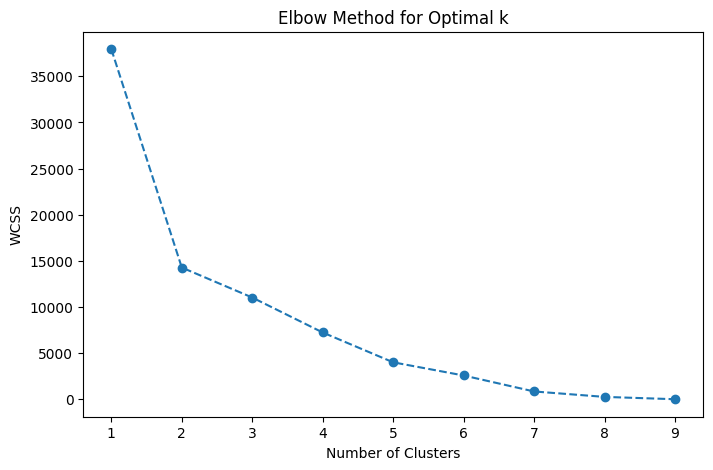

In [12]:
determine_optimal_clusters(mfcc_features)

In [13]:
cluster_raw_audio(padded_audio, file_names, 3)

Raw Audio Clustering Results:
1.wav: Cluster 2
2.wav: Cluster 1
3.wav: Cluster 1
4.wav: Cluster 0
5.wav: Cluster 1
6.wav: Cluster 1
7.wav: Cluster 1
8.wav: Cluster 1
9.wav: Cluster 1


In [14]:
cluster_mfcc_features(padded_audio, file_names, 3)


MFCC Feature Clustering Results:
1.wav: Cluster 2
2.wav: Cluster 0
3.wav: Cluster 2
4.wav: Cluster 0
5.wav: Cluster 0
6.wav: Cluster 1
7.wav: Cluster 0
8.wav: Cluster 0
9.wav: Cluster 0


In [19]:
true_clusters = [0, 1, 0, 2, 1, 1, 0, 2, 2]

In [26]:
def calculate_accuracy(true_labels, predicted_labels):
    """
    Maps the predicted labels to true labels using the Hungarian algorithm
    and computes clustering accuracy.
    """
    # Convert lists to NumPy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Create a confusion matrix
    max_label = max(true_labels.max(), predicted_labels.max()) + 1
    confusion_matrix = np.zeros((max_label, max_label), dtype=np.int64)
    
    for t, p in zip(true_labels, predicted_labels):
        confusion_matrix[t, p] += 1  # Populate confusion matrix

    # Apply the Hungarian algorithm to find the best label mapping
    row_ind, col_ind = linear_sum_assignment(confusion_matrix.max() - confusion_matrix)
    
    # Create a mapping from predicted to true labels
    label_mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # Convert predicted labels using the mapping
    mapped_preds = np.array([label_mapping[label] for label in predicted_labels])
    
    # Compute accuracy
    accuracy = accuracy_score(true_labels, mapped_preds)
    return accuracy, mapped_preds

# Compute accuracy for Raw Audio Clustering
raw_predicted_labels = perform_kmeans(padded_audio, 3)
raw_accuracy, raw_mapped_preds = calculate_accuracy(true_clusters, raw_predicted_labels)
print(f"Raw Audio Clustering Accuracy: {raw_accuracy:.4f}")

# Compute accuracy for MFCC-based Clustering
mfcc_features = extract_mfcc(padded_audio)
mfcc_predicted_labels = perform_kmeans(mfcc_features, 3)
mfcc_accuracy, mfcc_mapped_preds = calculate_accuracy(true_clusters, mfcc_predicted_labels)
print(f"MFCC Feature Clustering Accuracy: {mfcc_accuracy:.4f}")

Raw Audio Clustering Accuracy: 0.5556
MFCC Feature Clustering Accuracy: 0.6667
